**Навигация по уроку**
1. [Автокодировщик GAN. Генеративно-состязательные сети](https://colab.research.google.com/drive/15hs_BV9OGUuaTmVetqYaAUf8zpDgxz3_)
2. [Сверточные GAN. Генерация фейковых лиц](https://colab.research.google.com/drive/1mCDkjVfw4-ZWysmat7LH-xAmssZj6ANU)
3. [CyrcleGAN. Создаем картины в стиле Моне](https://colab.research.google.com/drive/1SKpzFYFsiU53E1BpRS4waNzQ_mVk-XMz)
4. Домашняя работа

В домашней работе вам необходимо выполнить одно из трёх заданий на выбор:

**Задание 1. На 3 балла:**

1. Ваша задача, используя датасет MNIST (из набора датасетов Tensorflow) научить GAN генерировать цифры.

2. Добейтесь хорошего качества генерации.

**Задание 2. На 4 балла:**

1. Ваша задача, используя датасет MNIST Fashion (из набора датасетов Tensorflow) научить GAN генерировать образцы одежды, соответственно.

2. Добейтесь хорошего качества генерации.

**Задание 3. На 5 баллов:**

1. Ваша задача, провести небольшое научное исследование, используя датасет MNIST Fashion (из набора датасетов Tensorflow) сравнить 2 разных модели DCGAN.

2. Необходимо, используя 2 разных генератора: классического GAN (на рис. 2. второй части урока) и улучшенного (из примера по генерации фейковых лиц), научить GAN генерировать образцы одежды.

2. Добейтесь хорошего качества генерации. Сравнить обе модели, сделайте выводы.

# Классический GAN

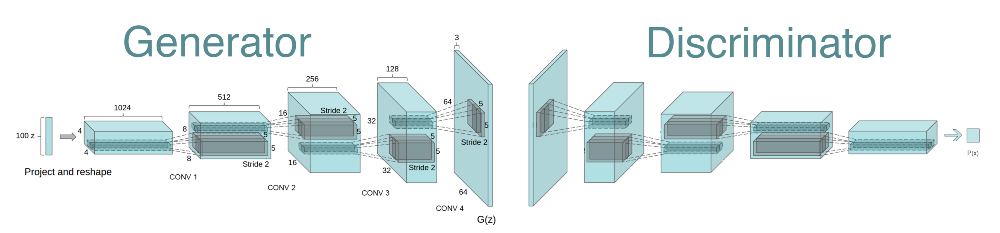

1. Совместимость с целевым размером изображения
Мы генерируем изображения 28x28 пикселей (для Fashion MNIST)

    28 можно разделить на 2^2 = 4 (2 слоя апсемплинга с stride=2)

    Исходный размер: 28 / 2 / 2 = 7

    Таким образом, 7x7 - это минимальный размер перед операциями апсемплинга

2. Постепенное увеличение разрешения
Архитектура использует 2 слоя Conv2DTranspose с stride=2:

3. Глубина каналов
    256 каналов выбраны как компромисс между:

    Достаточной емкостью для хранения информации

    Вычислительной эффективностью

    Типичные значения глубины в GAN: 512, 256, 128 (уменьшаются при увеличении разрешения)

4. Сравнение с оригинальной DCGAN-архитектурой
    В оригинальной статье DCGAN:

    Для 64x64 изображений использовали 4x4x1024

    Для 28x28 логично уменьшить до 7x7x256

Почему именно 7x7x256 лучше всего для MNIST?
Идеальное масштабирование:

7x7 → 14x14 → 28x28 (ровно в 2 раза на каждом шаге)

**Сбалансированная глубина:**

Начало с 256 каналов → 128 → 64 → 1

Прогрессивное уменьшение каналов при увеличении разрешения

**Экспериментально подтверждено:**

Такая конфигурация хорошо зарекомендовала себя в MNIST GAN

Дает стабильное обучение и качественные результаты

**Как изменить для других размеров изображений**

In [ ]:
initial_size = target_size // (2 ** num_upsampling_layers)
channels = base_channels * (2 ** (num_upsampling_layers - 1))

# Для 64x64 с 3 слоями апсемплинга:
# initial_size = 64 // 8 = 8
# channels = 256 * 4 = 1024 (если base_channels=256)
x = Dense(8*8*1024)(inputs)

## Импорты и Параметры обучения

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential
import numpy as np
import matplotlib.pyplot as plt
import os
import time

# Параметры обучения
batch_size = 128
latent_dim = 100
img_shape = (28, 28, 1)  # Для MNIST

# Загрузка и подготовка данных
(X_train, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
X_train = X_train / 127.5 - 1.0  # Нормализация в диапазон [-1, 1]
X_train = np.expand_dims(X_train, axis=-1)  # Добавляем канал

# Создаем Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [2]:
import os, time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Sequential

print("TensorFlow:", tf.__version__)

# --------------------------
# Гиперпараметры
# --------------------------
BATCH_SIZE   = 256
BUFFER_SIZE  = 60_000
EPOCHS       = 50
NOISE_DIM    = 100
NUM_EXAMPLES_TO_GENERATE = 16
LEARNING_RATE_G = 2e-4
LEARNING_RATE_D = 2e-4
BETA_1          = 0.5   # для Adam (рекомендуемо для GAN)

TensorFlow: 2.19.0


In [3]:
(x_train, _), _ = tf.keras.datasets.fashion_mnist.load_data()
# Нормируем к [-1, 1] под tanh в генераторе
x_train = (x_train.astype("float32") - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=-1)  # (28,28,1)

train_ds = (tf.data.Dataset
            .from_tensor_slices(x_train)
            .shuffle(BUFFER_SIZE, reshuffle_each_iteration=True)
            .batch(BATCH_SIZE, drop_remainder=True)
            .prefetch(tf.data.AUTOTUNE))

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## Классический Генератор

Можно вынести в функции построение схожих блоков, но я оставлю для наглядности полную картину слоев

In [4]:
def classic_generator():
    model = Sequential(name="Classic_Generator")
    # Проецируем и ресейпим в низкое разрешение (7x7x256)
    model.add(layers.Input(shape=(NOISE_DIM,)))
    model.add(layers.Dense(7*7*256, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Reshape((7, 7, 256)))   # 7x7x256

    # 7x7 -> 14x14
    model.add(layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # 14x14 -> 28x28
    model.add(layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # Выходной слой: 28x28x1
    model.add(layers.Conv2DTranspose(1, kernel_size=5, strides=1, padding='same', activation='tanh'))
    return model

generator = classic_generator()
generator.summary()

Model: "Classic_Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 128)    │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │         1,601 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,330,945 (8.89 MB)

 Trainable params: 2,305,473 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

## Классический Дискриминатор

In [5]:
def classic_discriminator():
    model = Sequential(name="Classic_Discriminator")
    model.add(layers.Input(shape=(28, 28, 1)))

    model.add(layers.Conv2D(64, kernel_size=5, strides=2, padding='same', kernel_initializer='he_normal'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, kernel_size=5, strides=2, padding='same', kernel_initializer='he_normal'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))  # логиты без активации
    return model

discriminator = classic_discriminator()
discriminator.summary()

Model: "Classic_Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

## Обучение классической архитектуры

### Loss

In [6]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_logits, fake_logits):
    real_loss = cross_entropy(tf.ones_like(real_logits), real_logits)    # метки 1 для реальных
    fake_loss = cross_entropy(tf.zeros_like(fake_logits), fake_logits)   # метки 0 для фейков
    return real_loss + fake_loss

def generator_loss(fake_logits):
    # хотим "обмануть" дискриминатор: метки как у реальных (1)
    return cross_entropy(tf.ones_like(fake_logits), fake_logits)

generator_optimizer     = tf.keras.optimizers.Adam(LEARNING_RATE_G, beta_1=BETA_1)
discriminator_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE_D, beta_1=BETA_1)

### Визуализация

In [39]:
seed = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, NOISE_DIM])

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    predictions = (predictions + 1.0) / 2.0  # обратно к [0,1] для отображения

    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    os.makedirs(f"samples_{model.name}", exist_ok=True)
    fname = f"samples_{model.name}/epoch_{epoch:03d}.png"
    plt.savefig(fname, bbox_inches='tight')
    plt.show()
    print(f"Сохранено: {fname}")

### Функции шага обучения

In [40]:
@tf.function
def train_step(generator, discriminator, generator_optimizer,
               discriminator_optimizer, real_images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    # Обновляем дискриминатор
    with tf.GradientTape() as disc_tape:
        fake_images = generator(noise, training=True)

        real_logits = discriminator(real_images, training=True)
        fake_logits = discriminator(fake_images, training=True)

        d_loss = discriminator_loss(real_logits, fake_logits)

    d_grads = disc_tape.gradient(d_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(d_grads, discriminator.trainable_variables))

    # Обновляем генератор
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
    with tf.GradientTape() as gen_tape:
        generated_images = generator(noise, training=True)
        fake_logits = discriminator(generated_images, training=True)
        g_loss = generator_loss(fake_logits)

    g_grads = gen_tape.gradient(g_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(g_grads, generator.trainable_variables))

    return g_loss, d_loss

### Цикл обучения по эпохам

In [41]:
def train(generator, discriminator, generator_optimizer,
          discriminator_optimizer, dataset, epochs):
    start_time = time.time()
    for epoch in range(1, epochs+1):
        g_losses, d_losses = [], []
        for real_batch in dataset:
            g_loss, d_loss = train_step(generator, discriminator, generator_optimizer,
                                        discriminator_optimizer, real_batch)
            g_losses.append(g_loss)
            d_losses.append(d_loss)

        # визуализируем прогресс
        generate_and_save_images(generator, epoch, seed)

        print(f"Эпоха {epoch}/{epochs} | "
              f"G_loss={tf.reduce_mean(g_losses):.4f} | "
              f"D_loss={tf.reduce_mean(d_losses):.4f}")

    print(f"Готово за {(time.time()-start_time)/60:.2f} мин.")

In [10]:
train(generator, discriminator, generator_optimizer, discriminator_optimizer, train_ds, EPOCHS)

Output hidden; open in https://colab.research.google.com to view.

### Генерация изображений

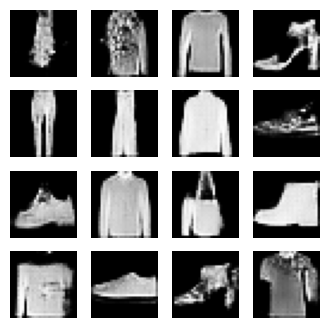

In [11]:
noise = tf.random.normal([16, NOISE_DIM])
gen_imgs = generator(noise, training=False)
gen_imgs = (gen_imgs + 1.0) / 2.0

fig = plt.figure(figsize=(4,4))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(gen_imgs[i,:,:,0], cmap='gray')
    plt.axis('off')
plt.show()

---

# Улучшеный DCGAN

Отличается тем, что использует в качестве генератора автокодировщик и двойные слои свертки в моделях генератора и дискриминатора.

## Генератор

In [43]:
def make_DC_generator():
    model = Sequential(name="DC_Generator")

    # Вход: латентный вектор
    model.add(layers.Dense(28*28*1, use_bias=False, input_shape=(NOISE_DIM,)))
    model.add(layers.Reshape((28,28,1)))  # (28,28,1)

    # Downsampling (двойные Conv2D)
    model.add(layers.Conv2D(64, 4, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(layers.Conv2D(64, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(128, 4, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(layers.Conv2D(128, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Bottleneck (Conv2DTranspose + Conv2D)
    model.add(layers.Conv2DTranspose(256, 4, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(layers.Conv2D(256, 4, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(layers.LeakyReLU())

    # Upsampling (двойные Conv2DTranspose)
    model.add(layers.Conv2DTranspose(256, 4, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(layers.Conv2DTranspose(256, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, 4, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(layers.Conv2DTranspose(128, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(layers.BatchNormalization())

    # Финальное восстановление в 28x28x1
    model.add(layers.Conv2DTranspose(64, 4, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2DTranspose(1, 4, strides=1, padding='same', activation='tanh'))

    return model

DC_gen = make_DC_generator()
DC_gen.summary()

Model: "DC_Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_13 (Dense)                │ (None, 784)            │        78,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_7 (Reshape)             │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 28, 28, 64)     │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 14, 14, 64)     │        65,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_56 (LeakyReLU)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 14, 14, 128)    │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 7, 7, 128)      │       262,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_57 (LeakyReLU)      │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_47             │ (None, 7, 7, 256)      │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 7, 7, 256)      │     1,048,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_58 (LeakyReLU)      │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_48             │ (None, 7, 7, 256)      │     1,048,576 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_49             │ (None, 14, 14, 256)    │     1,048,576 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_59 (LeakyReLU)      │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_50             │ (None, 14, 14, 128)    │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_51             │ (None, 28, 28, 128)    │       262,144 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,129,281 (19.57 MB)

 Trainable params: 5,128,001 (19.56 MB)

 Non-trainable params: 1,280 (5.00 KB)

## Дискриминатор

In [42]:
def make_DC_discriminator():
    model = Sequential(name="DC_Discriminator")

    # Вход: 28x28x1
    model.add(layers.Input(shape=(28, 28, 1)))

    # Блок 1: 28x28 -> 14x14
    model.add(layers.Conv2D(64, 4, strides=2, padding='same', kernel_initializer='he_normal'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Conv2D(64, 4, strides=1, padding='same', kernel_initializer='he_normal'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    # Блок 2: 14x14 -> 7x7
    model.add(layers.Conv2D(128, 4, strides=2, padding='same', kernel_initializer='he_normal'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Conv2D(128, 4, strides=1, padding='same', kernel_initializer='he_normal'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    # Блок 3: 7x7 -> 4x4
    model.add(layers.Conv2D(256, 4, strides=2, padding='same', kernel_initializer='he_normal'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Conv2D(256, 4, strides=1, padding='same', kernel_initializer='he_normal'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    # Выход
    model.add(layers.Flatten())
    model.add(layers.Dense(1))  # логит (без сигмоиды!)

    return model

# Проверим
DC_disc = make_DC_discriminator()
DC_disc.summary()

Model: "DC_Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_56 (Conv2D)              │ (None, 14, 14, 64)     │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_50 (LeakyReLU)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 14, 14, 64)     │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_51 (LeakyReLU)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 7, 7, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_52 (LeakyReLU)      │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 7, 7, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_53 (LeakyReLU)      │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 4, 4, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_54 (LeakyReLU)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 4, 4, 256)      │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_55 (LeakyReLU)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,037,633 (7.77 MB)

 Trainable params: 2,037,633 (7.77 MB)

 Non-trainable params: 0 (0.00 B)

## Оптимизаторы

In [44]:
DC_generator_optimizer     = tf.keras.optimizers.Adam(LEARNING_RATE_G, beta_1=BETA_1)
DC_discriminator_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE_D, beta_1=BETA_1)

## Обучение

In [45]:
train(DC_gen, DC_disc, DC_generator_optimizer, DC_discriminator_optimizer, train_ds, EPOCHS)

Output hidden; open in https://colab.research.google.com to view.

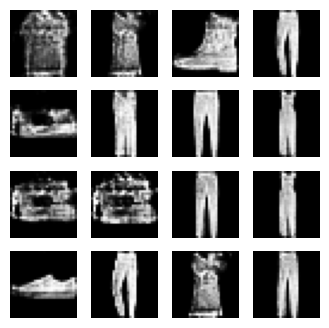

In [46]:
noise = tf.random.normal([16, NOISE_DIM])
gen_imgs = DC_gen(noise, training=False)
gen_imgs = (gen_imgs + 1.0) / 2.0

fig = plt.figure(figsize=(4,4))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(gen_imgs[i,:,:,0], cmap='gray')
    plt.axis('off')
plt.show()

# Итог

Мы обучили 2 GAN модели: простую классическую, которая разворачивает картинку из шума, и более сложную, в которой используется автокодировщик в качестве генератора.

Качество генерации обеих после 50 эпох обучения показывает приемлемые результаты. Однако, можно заметить, что для такого простого формата изображений, как Fashin MNIST более эффективной оказалась простая модель, так как уменьшеный размер генератора позволил ему обучиться быстрее, а размер изображений для обучения был достаточно мал, чтобы генерировать подходящего качества изображения.

Так же можно заметить, что классический GAN строил более разнообразные изображения, а глубокая модель выдавала меньше различных вариантов.

Увеличенная модель DCGAN с двойными слоями требует большего времени чтобы раскачать все слои сверток, тогда как задача дискриминатора легче и ему проще обучиться отличать подделку. Когда дичкриминатор начинает доминировать, он так же начинает тормозить обучение генератора, что еще более усложняет задачу. Такой подход больше подходит для изображений и датасетов, где содержатся больше примеров для сравнения и требуется более детальное изображение.